# Isaac Rodriguez Bribiesca
## Procesamiento de Lenguaje Natural
## Práctica 4: TCOR

### Lectura simple de datos

In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_truth:
            tr_y += [label]        
    return tr_txt, tr_y



Using TensorFlow backend.


In [2]:
tr_txt, tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

### Estadisticas Simples

In [3]:
tr_y = list(map(int, tr_y))

Counter({0: 3563, 1: 1981})


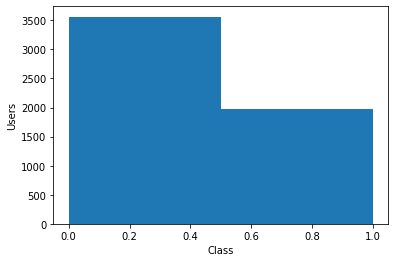

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users');
plt.xlabel('Class');

# Un ojo a los datos

In [5]:
tr_txt[:10]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

### Construcción simple del vocabulario

In [6]:
import nltk

In [7]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += doc.split()
#print(corpus_palabras)
fdist = nltk.FreqDist(corpus_palabras)

In [8]:
fdist

FreqDist({'de': 3342, 'que': 3336, 'a': 2605, 'la': 2417, 'y': 2225, 'no': 1743, 'me': 1582, 'el': 1285, '@usuario': 1243, 'en': 1184, ...})

In [9]:
len(fdist)

17055

In [10]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [11]:
V = sortFreqDict(fdist)
V = V[:5000]

In [12]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1   

### Bolsa de Términos

In [13]:
import numpy as np
def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt),len(V)), dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tr.split())
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
        
    return BOW

### Debug?

In [14]:
tr_txt[10]

'"no me importa lo que digan esos putos periodistas la puta que los pario oh oh oh hay que alentar a la selección"\n'

In [15]:

fdist_doc = nltk.FreqDist(tr_txt[10].split())

In [16]:
fdist_doc

FreqDist({'que': 3, 'oh': 3, 'la': 2, '"no': 1, 'me': 1, 'importa': 1, 'lo': 1, 'digan': 1, 'esos': 1, 'putos': 1, ...})

### Bolsa de Terminos en Validación

In [17]:
BOW_tr=build_bow_tr(tr_txt, V, dict_indices)

In [18]:
print(V[:10])

[(3342, 'de'), (3336, 'que'), (2605, 'a'), (2417, 'la'), (2225, 'y'), (1743, 'no'), (1582, 'me'), (1285, 'el'), (1243, '@usuario'), (1184, 'en')]


In [19]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
#print(BOW[10])

In [20]:
val_txt, val_y = get_texts_from_file("./mex_val.txt", "./mex_val_labels.txt")

In [21]:
val_y = list(map(int, val_y))

Counter({0: 397, 1: 219})


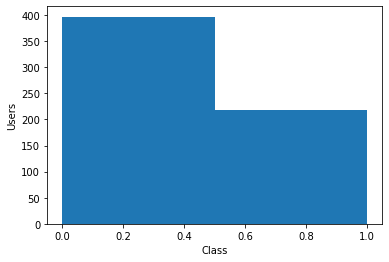

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel('Users');
plt.xlabel('Class');

In [23]:
val_txt[:10]

['así debería ser siempre para que se mueran a la verga\n',
 'cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤\n',
 'hijo de tu puta madre nadamas te la pasas mamando pinche wilo de closet\n',
 'soñé horrible espero no se cumpla putos temblores.\n',
 '@usuario mejor vas y la chingas tú veo tus publicaciones y solo denotan inconformidad como típico ciudadano quejumbroso que no hace nada por cambiar\n',
 'y quizás este loca y quizás me guste estarlo... #siempreneruda\n',
 'me tienen hasta la verga con sus putos #boomerang pendejos y sin sentido.\n',
 'cuando va a ser el día que encuentre a alguien en quien pueda  confiar posts la re puta madre?\n',
 '#ahoritaestoypensando  como putas puede pasar esto?\n',
 '#todoibabienpero valio madre ya me atacó el insomnio🙅\n']

In [24]:
BOW_val=build_bow_tr(val_txt, V, dict_indices)

# Esta es la única parte de la Práctica!!!

In [47]:
import math

def compute_tcor(BOW):
    #TCOR: (1 + math.log10(doc[term])) * math.log10(V_size/v_size)
    
    DTR = np.zeros((BOW.shape[1], BOW.shape[1]), dtype=np.float)

    tam_V = DTR.shape[1]
    
    for i in range(BOW.shape[1]):
        
        nonzero_positions = np.nonzero(BOW[:,i])[0]
        
        tam_v = 0
        
        for pos in nonzero_positions:
            
            tam_v = max(tam_v, np.count_nonzero(BOW[pos,:]))
        
        for j in range(i,BOW.shape[1]):
            
            if i == j:
                DTR[i][j] = 1
            
            else:
                
                match = np.logical_and(BOW[:,i] > 0, BOW[:,j] > 0)
            
                tf = np.count_nonzero(match)
                
                if tf > 0:
                    tf = 1 + math.log10(tf)
                else:
                    tf = 0
                
                DTR[i][j] = tf*math.log10(tam_V/tam_v)
    
    return DTR

In [48]:
from sklearn import preprocessing
TCOR_base = compute_tcor(BOW_tr)
TCOR_base = preprocessing.normalize(TCOR_base, norm='l2')

# Hay muchas formas de seleccionar las mejores características (Tal vez después veamos alguna). De momento usamos Chi2 para seleccionar las 1000 mejores características a partir de la BOW

In [38]:
from sklearn.feature_selection import SelectKBest, chi2
feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr, tr_y)

SelectKBest(k=1000, score_func=<function chi2 at 0x7febf64ce950>)

In [39]:
best=feats.get_support(indices=True)

In [40]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w

In [41]:
target_words = [dict_indice_invertido[index] for index in best]
words = [word for word in target_words if word in dict_indices] 
target_matrix = np.array([TCOR_base[dict_indices[word]] for word in words])

In [42]:
target_matrix.shape

(1000, 5000)

In [43]:
from tsne import tsne
reduced_matrix = tsne(target_matrix, 2);

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.114218
Iteration 10: error is 17.543659
Iteration 20: error is 16.646038
Iteration 30: error is 15.955695
Iteration 40: error is 16.044430
Iteration 50: error is 16.096081
Iteration 60: error is 16.117789
Iteration 70: error is 16.092268
Iteration 80: error is 16.015328
Iteration 90: error is 16.031274
Iteration 100: error is 16.038591
Iteration 110: error is 1.911867
Iteration 120: error is 1.394932
Iteration 130: error is 1.169594
Iteration 140: error is 1.052179
Iteration 150: error is 0.975882
Iteration 160: error is 0.925298
Iteration 170: error is 0.889425
Iteration 180: error is 0.862007
Iteration 190: error is 0.840302
Iteration 200: error is 0.822712
Iteration 210: error is 0.808296
Iteration 220: error is 0.796484
Iteration 230: error is 0.786701
Iteration 240: error is 0.778620
Iteration 250: error is

In [44]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

# HE AQUI LA SALIDA ESPERADA!!!

/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 129300 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:1

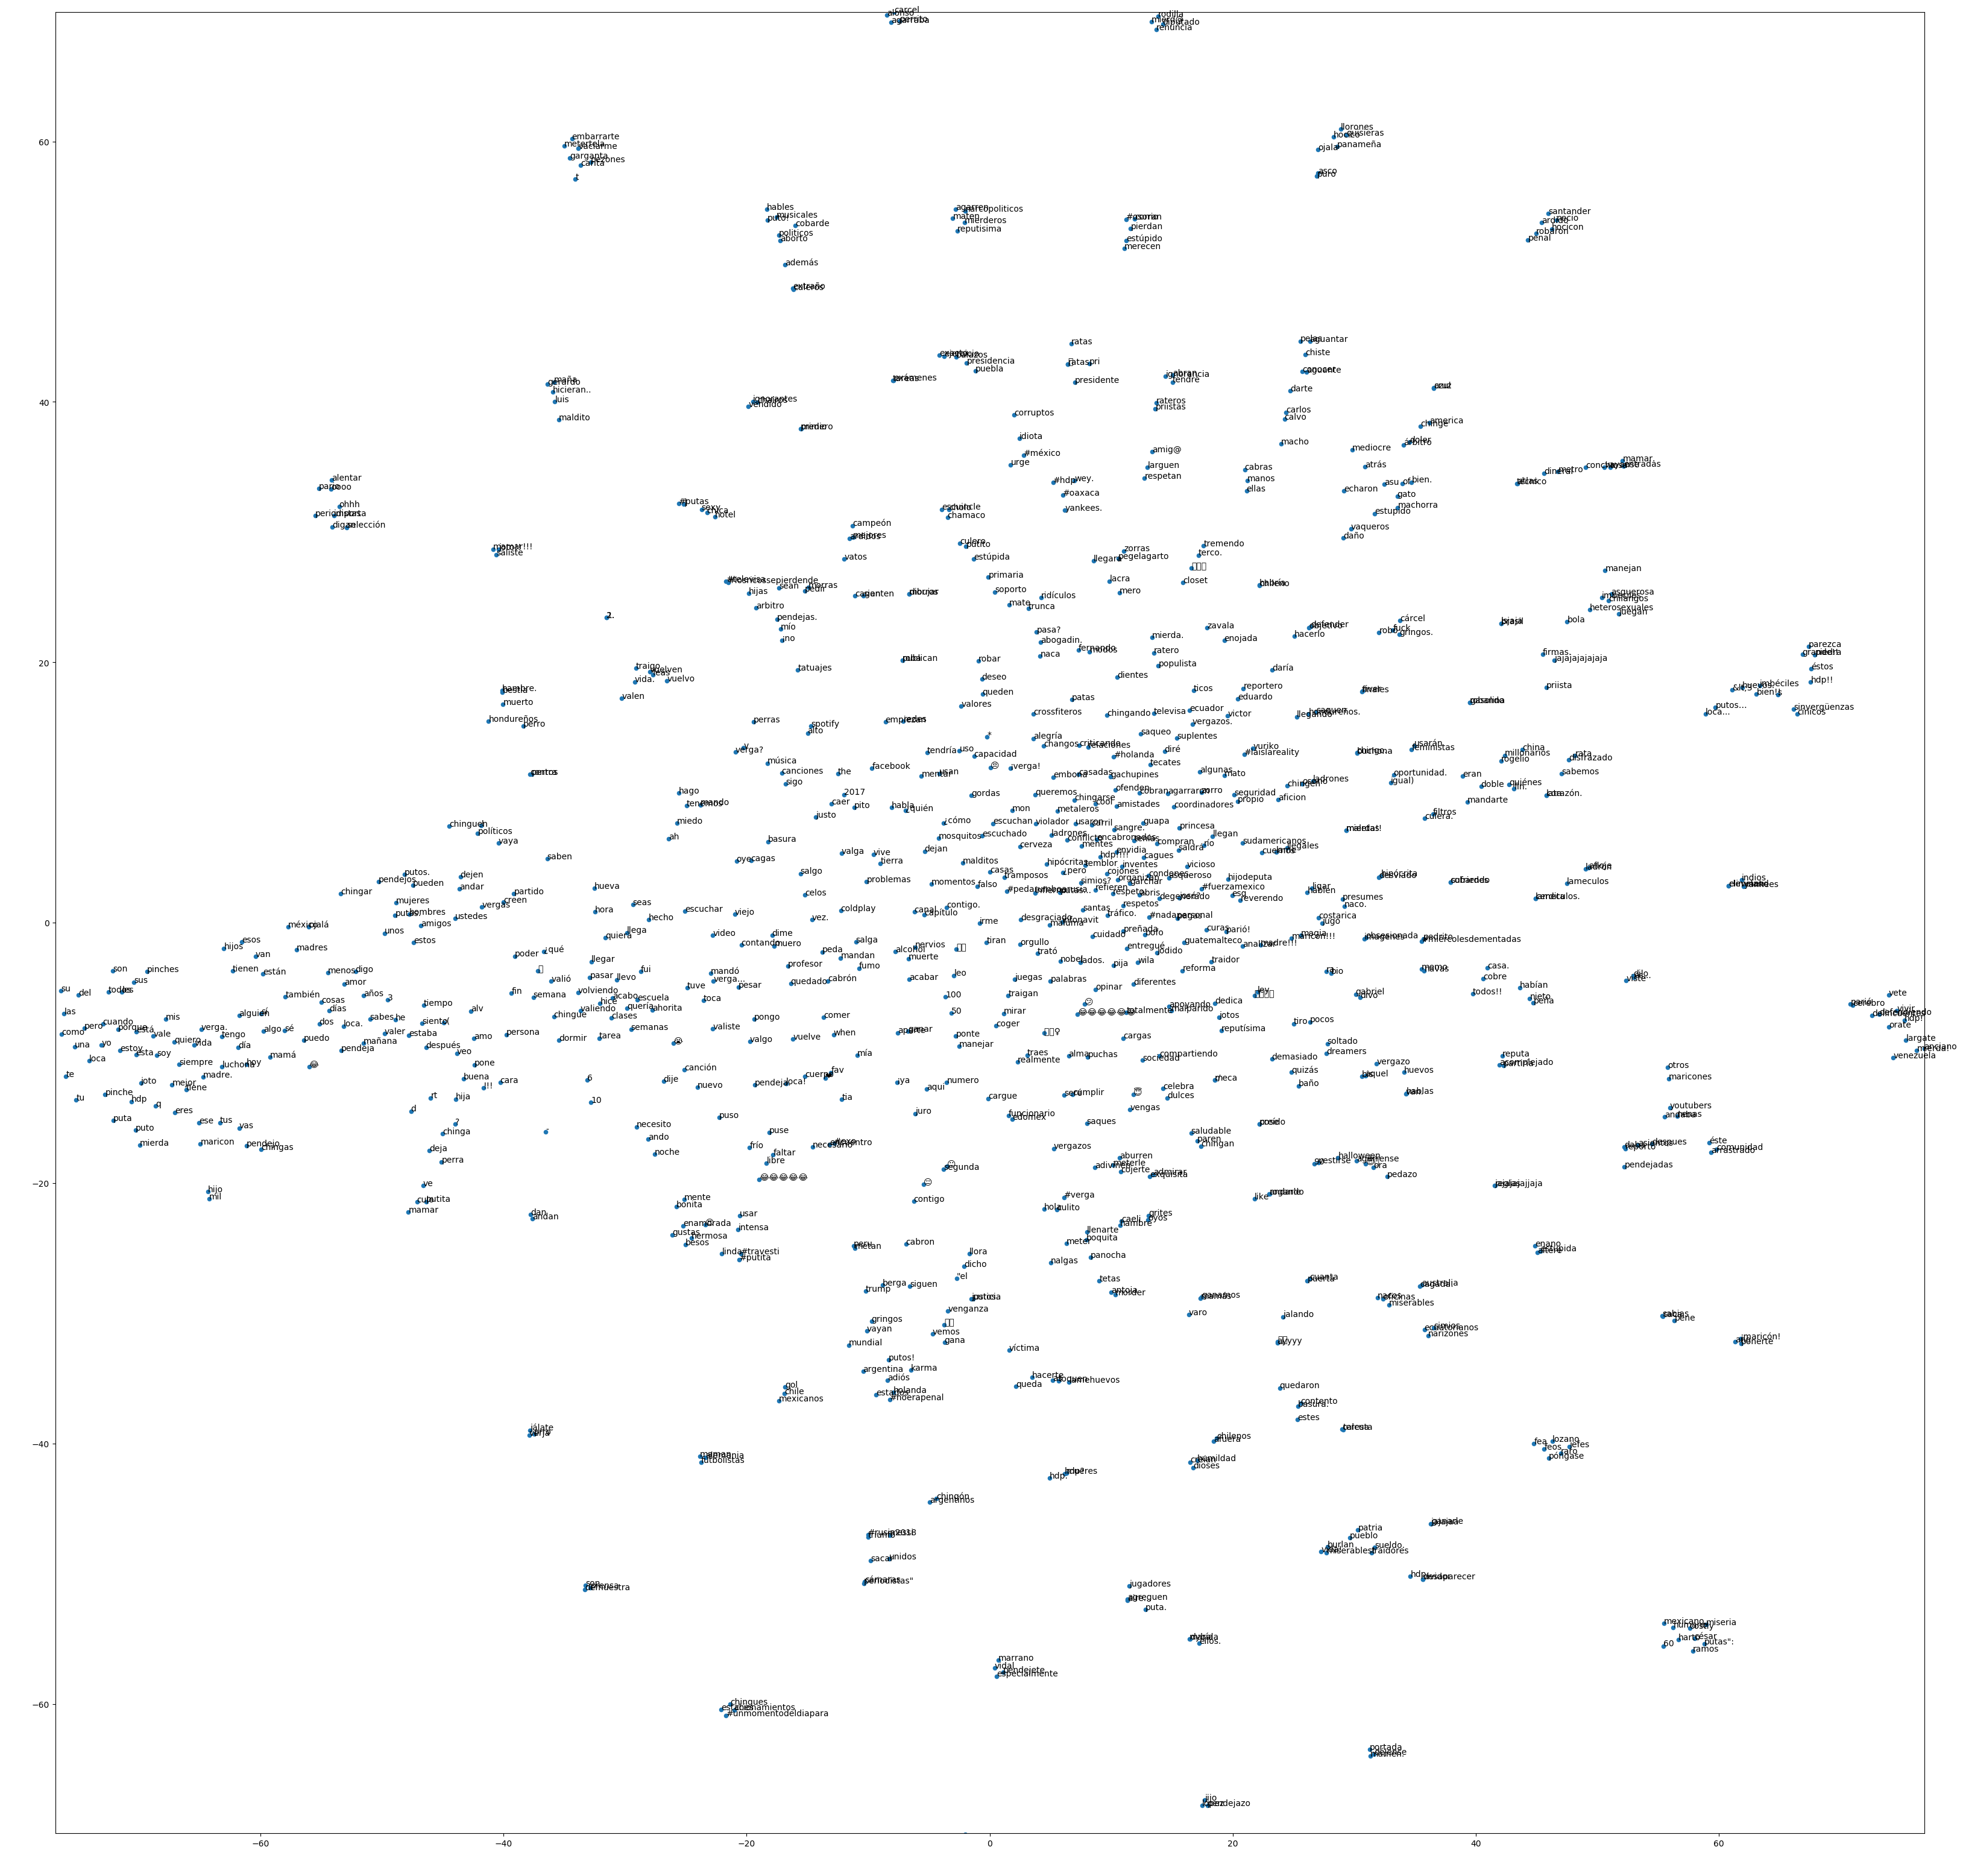

In [45]:
plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20);
for idx, word in enumerate(words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y))